# MNIST Digit Classification

Using standard out of box methods for machine learning one can achieve high levels of acccuracy for reading handwritten characters. Stochastic gradient descent and random forest classifiers are used while tuning the hyperparameters to achieve a very high level of accuracy.

# Data Preparation

Scikit-learn has its own repository of standard datasets that can be used to practice its machine learning capabilities. In particular the MNIST is the most iconic dataset containing 70,000 instances of 28x28 handwritten digits and is the textbook dataset for any beginner machine learning practitioner

In [1]:
from sklearn.datasets import fetch_mldata
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

mnist = fetch_mldata('MNIST Original')
X, y = mnist["data"], mnist["target"]
print(X.shape,y.shape)

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

(70000, 784) (70000,)


Data is represented as a 784 dimension vector but is really a 28x28 pixel image. The intensity varies from 0 to 255 which is the grayscale value. We can recover this representation by reshaping the vector using numpy and matplotlibs imshow method.

# Training Model

In [2]:
import pandas as pd

train_data = pd.DataFrame(pd.read_csv("./train.csv"))
test_data = pd.DataFrame(pd.read_csv("./test.csv"))

In [3]:
train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
X_train = train_data.drop(['label'], axis=1)
y_train = train_data['label']

In [5]:
X_train.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state = 42)

Prior to training one must rescale the data otherwise nodes with 

In [7]:
X_train = X_train / 255
X_val = X_val / 255

Using TensorFlow backend.


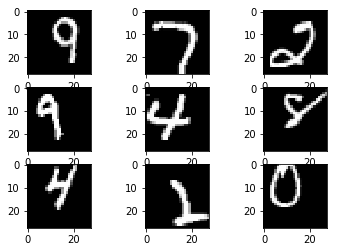

In [8]:
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from keras import backend as K
from keras.datasets import mnist
K.set_image_dim_ordering('th')
import numpy as np

X_array = np.array(X_train)
X_array = X_array.reshape(X_train.shape[0],1,28,28)
X_array = X_array.astype('float32')

shift = 0.2
datagen = ImageDataGenerator(width_shift_range = shift, height_shift_range= shift)
datagen.fit(X_array)
# Get one of the batch images
for X_batch, y_batch in datagen.flow(X_array, y_train, batch_size=9):
    for i in range(0,9):
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(X_batch[i].reshape(28, 28), cmap = pyplot.get_cmap('gray'))
    pyplot.show()
    break

In [9]:
for X_batch, y_batch in datagen.flow(X_array, y_train, batch_size=len(X_train)):
    X_train_shift = X_batch.reshape(len(X_train),784)
    y_train_shift = y_batch
    break

In [10]:
print(X_train_shift.shape)
print(y_train_shift.shape)

(33600, 784)
(33600,)


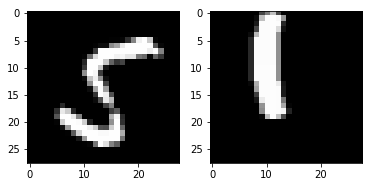

In [11]:
f, axarr = pyplot.subplots(ncols=2)
axarr[0].imshow(X_train.values[1].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axarr[1].imshow(X_train_shift[1].reshape(28, 28), cmap=pyplot.get_cmap('gray'))
pyplot.show()

In order to make use of the convolutions we must convert the training data into an array to preserve the spatial structure of the pixels.

In [13]:
from keras.utils import np_utils

X_train_array = np.array(X_train).reshape(len(X_train), 1, 28, 28)
X_test_val_array = np.array(X_val).reshape(len(X_val), 1, 28, 28)
y_cat = np_utils.to_categorical(y_train,10)

In [14]:
from keras.models import Sequential
from keras.layers.core import Dropout, Activation, Dense, Flatten
from keras.optimizers import SGD
from keras.layers import Conv2D, MaxPooling2D

def keras_model(activation = 'relu', dropout=0.2, nodes_per_layer = 32, loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy']):
    my_model = Sequential()
    my_model.add(Conv2D(filters=32, kernel_size = (2,2), padding='same', activation = 'relu', input_shape = (1, 28,28)))
    my_model.add(MaxPooling2D(pool_size=(2,2)))
    my_model.add(Dropout(dropout))
    my_model.add(Conv2D(filters=64, kernel_size = (2,2), padding='same', activation='relu'))
    my_model.add(MaxPooling2D(pool_size=(2,2)))
    my_model.add(Dropout(dropout))
    my_model.add(Conv2D(filters=128, kernel_size=(2,2), padding='same', activation='relu'))
    my_model.add(MaxPooling2D(pool_size=(2,2)))
    my_model.add(Dropout(dropout))
    my_model.add(Flatten())
    my_model.add(Dense(nodes_per_layer, activation=activation))
    my_model.add(Dense(10, activation="softmax"))
    
    my_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return my_model

Build a simple 3 layer convolution with max pooling and a fully connected layer. Activations are all ReLU except for in the dense penultimate dense layer. Kernel size 2 to reduce the filter size.

In [15]:
my_model = keras_model()
my_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 28, 28)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 14, 14)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 14, 14)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 14, 14)        8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 7, 7)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64, 7, 7)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 7, 7)         32896     
__________

In [17]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)
my_model.fit(X_train_array, y_cat, batch_size=128, epochs=20, callbacks=[checkpointer])

Epoch 1/20
33600/33600 [==============================] - 205s 6ms/step - loss: 1.8164 - acc: 0.3919
Epoch 2/20
33600/33600 [==============================] - 204s 6ms/step - loss: 0.9989 - acc: 0.6751
Epoch 3/20
33600/33600 [==============================] - 193s 6ms/step - loss: 0.6413 - acc: 0.7964
Epoch 4/20
33600/33600 [==============================] - 212s 6ms/step - loss: 0.4720 - acc: 0.8518
Epoch 5/20
33600/33600 [==============================] - 208s 6ms/step - loss: 0.3735 - acc: 0.8822
Epoch 6/20
33600/33600 [==============================] - 200s 6ms/step - loss: 0.2954 - acc: 0.9099
Epoch 7/20
12288/33600 [=========>....................] - ETA: 2:14 - loss: 0.3042 - acc: 0.8993

KeyboardInterrupt: 

Using the Keras wrapper we can create a sci-kit learn classifier and run hyperparameter tuning on it.

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
keras_model_sk = KerasClassifier(build_fn=keras_model,epochs=50,batch_size=1000)

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'dropout': [0.2, 0.4, 0.6, 0.8],
}

grid_search = GridSearchCV(keras_model_sk, param_grid = param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_cat)

In [78]:
grid_search.best_params_


{'dropout': 0.8}

In [69]:
predictions = grid_search.evaluate(X_train, y_cat)
predictions[1]

33600/33600 [==============================] - 32s 940us/step


0.0

Shift the image by random pixels in various dimensions to create additional data to train on.

Change the dataset by changing the brightness of certain sections.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from keras import backend as K
K.set_image_dim_ordering('th')

X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
X_train = X_train.astype('float32')

datagen = ImageDataGenerator(zca_whitening=True)
datagen.fit(X_train)

for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
    # 3x3 images
    for i in range(0, 9):
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(X_batch[i].reshape(28, 28), cmap=pyplot.get_cmap('gray'))
    pyplot.show()
    break

In [ ]:
X_train_augmented = pd.DataFrame(X_train)
y_train_augmented = pd.DataFrame(y_train)

for dx, dy in ((1,0), (0,1), (-1,0), (0,-1)):
    for i in range(1, len(y_train)):
        if i%1000 == 0: print(i)
        X_train_augmented.append(shift_image(X_train[i:i+1].values,dx,dy))
        y_train_augmented.append(y_train[i:i+1])

In [ ]:
from sklearn.decomposition import IncrementalPCA, PCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)
    
pca = PCA(n_components=0.95)
X_reduced = inc_pca.transform(X_train)

In [ ]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, OneVsRestClassifier
forest_clf = RandomForestClassifier()
y_scores = cross_val_predict(forest_clf, X_reduced, y_train, cv=5)
y_scores_no_reduce = cross_val_predict(forest_clf, X_train, y_train, cv=5)

In [ ]:
from sklearn.svm import SVC

n_estimators = 10
bagging_clf = OneVsRestClassifier(BaggingClassifier(SVC(kernel='linear', probability=True), max_samples = 1.0/n_estimators, n_estimators = n_estimators))

bagging_clf.fit(X_train, y_train)
bagging_pred = bagging_clf.predict(X_train)
accuracy_score(y_train, bagging_pred)


In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_train, y_scores)
accuracy2 = accuracy_score(y_train, y_scores_no_reduce)